# Tuần 1-2: Phân tích bài toán, tìm hiểu dataset, xây dựng baseline

In [1]:
from src.utils import download_data
from src.config import Config
from src.eda import *
from src.dataloader import load_captions_data
from src.preprocess import *
from src.model import *
import os


Tải dữ liệu từ kaggle

[utils.py](../src/utils.py)

In [2]:
download_data()

Data đã tồn tại


## 1. Phân tích dataset

In [3]:
if os.path.exists(Config.CAPTION):
    data = load_captions_data(Config.CAPTION)
else:
    print(f"LỖI: Không tìm thấy file tại {Config.CAPTION}")
    data = {}

# --- HIỂN THỊ CẤU TRÚC CỦA BIẾN DATA ---
if len(data) > 0:
    first_key = list(data.keys())[0]
    print(f"\nVí dụ cấu trúc biến 'data':")
    print(f"Key (Tên ảnh): {first_key}")
    print(f"Value (List Captions): {data[first_key]}")

Đang đọc file caption từ: ../data/flickr8k/captions.txt
Đã load xong dữ liệu của 8091 ảnh.

Ví dụ cấu trúc biến 'data':
Key (Tên ảnh): 1000268201_693b08cb0e.jpg
Value (List Captions): ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


1. Phân tích Caption

=== THỐNG KÊ ĐỘ DÀI CAPTION ===
total_captions: 40455.00
min_len: 1.00
max_len: 38.00
mean_len: 11.78
median_len: 11.00
std_dev: 3.89


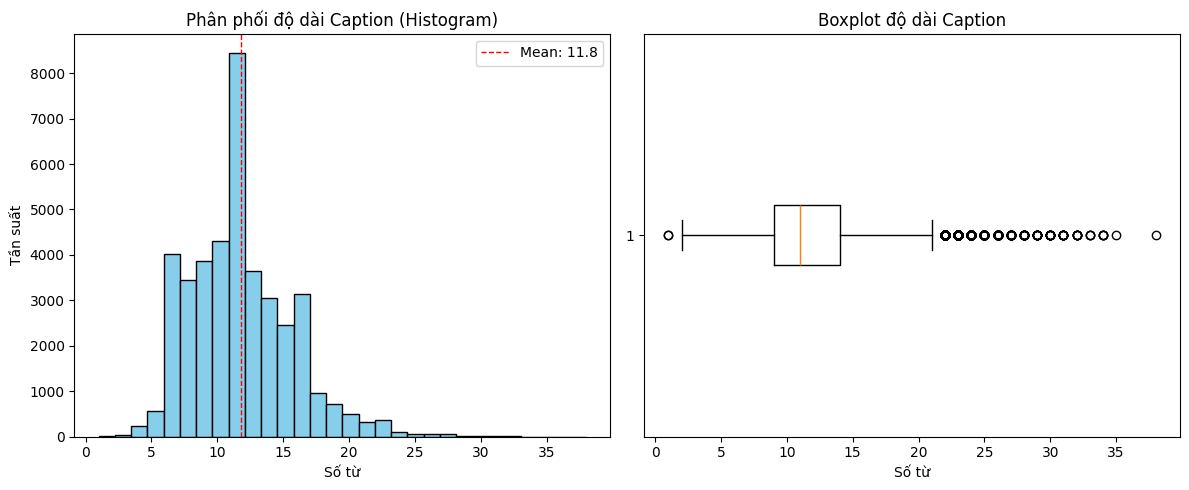

In [4]:
caption_stats = analyze_caption_lengths(data)

2. Phân tích Từ vựng

=== THỐNG KÊ TỪ VỰNG ===
Tổng số từ (Tokens): 436856
Kích thước từ điển (Unique words): 8911
Số từ chỉ xuất hiện 1 lần: 3676 (41.25%)


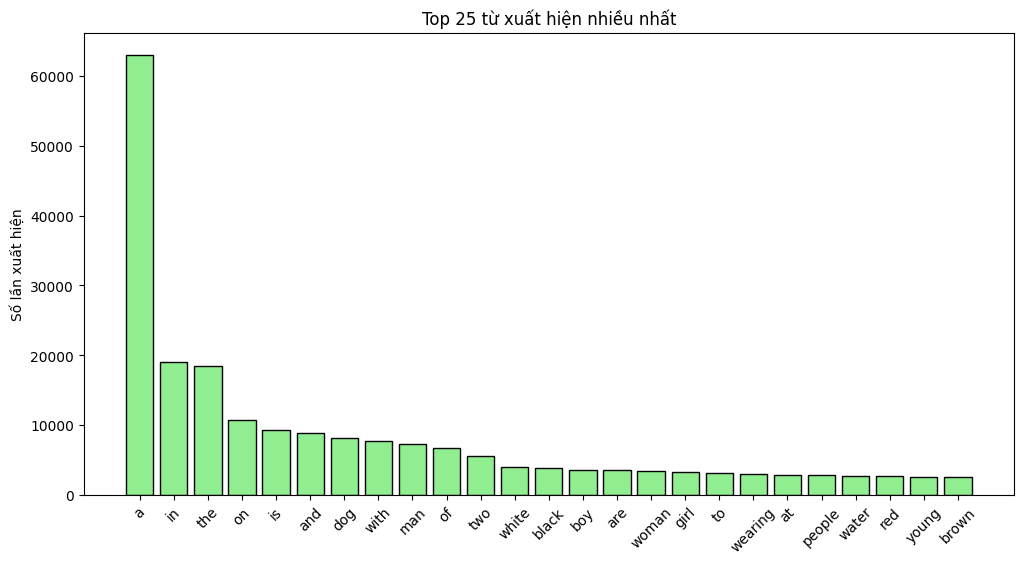

In [5]:
vocab_counter = analyze_vocabulary(data, top_n=25)

3. Phân tích Ảnh (Chạy trên 1000 ảnh mẫu cho nhanh)

Đang phân tích 1000 ảnh...


100%|██████████| 1000/1000 [00:01<00:00, 963.30it/s]


=== THỐNG KÊ KÍCH THƯỚC ẢNH ===
Width  - Min: 200, Max: 500, Mean: 457.1
Height - Min: 187, Max: 500, Mean: 397.1


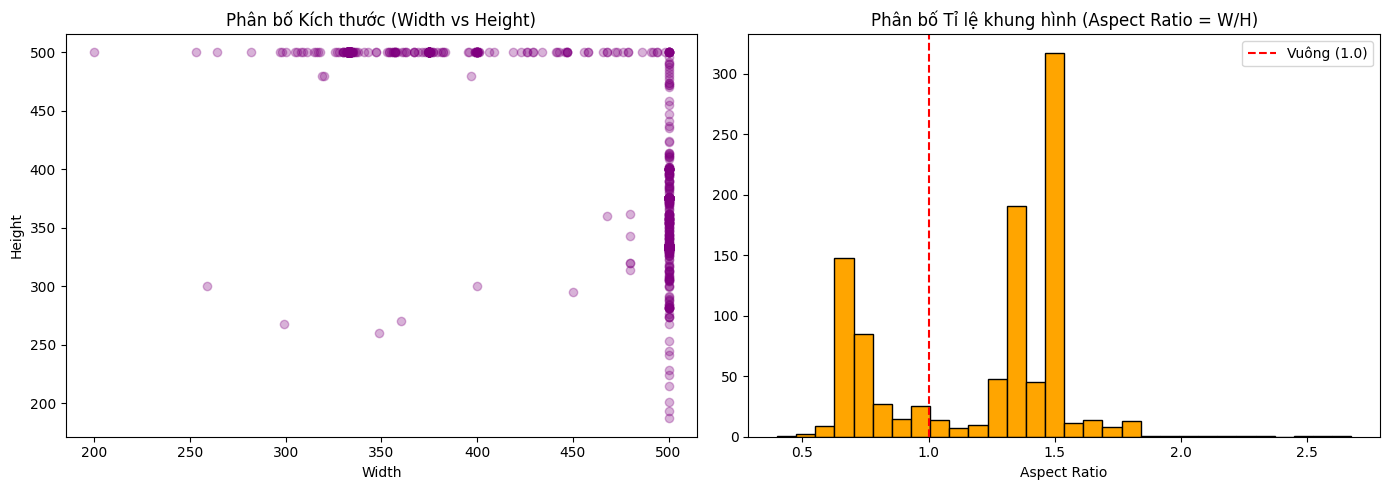

In [6]:
analyze_image_specs(data, Config.IMG_DIR)

4. Kiểm tra file

In [7]:
check_dataset_integrity(data, Config.IMG_DIR)

✅ Kiểm tra hoàn tất: Tất cả ảnh đều tồn tại.


[]

5. Xem ảnh mẫu

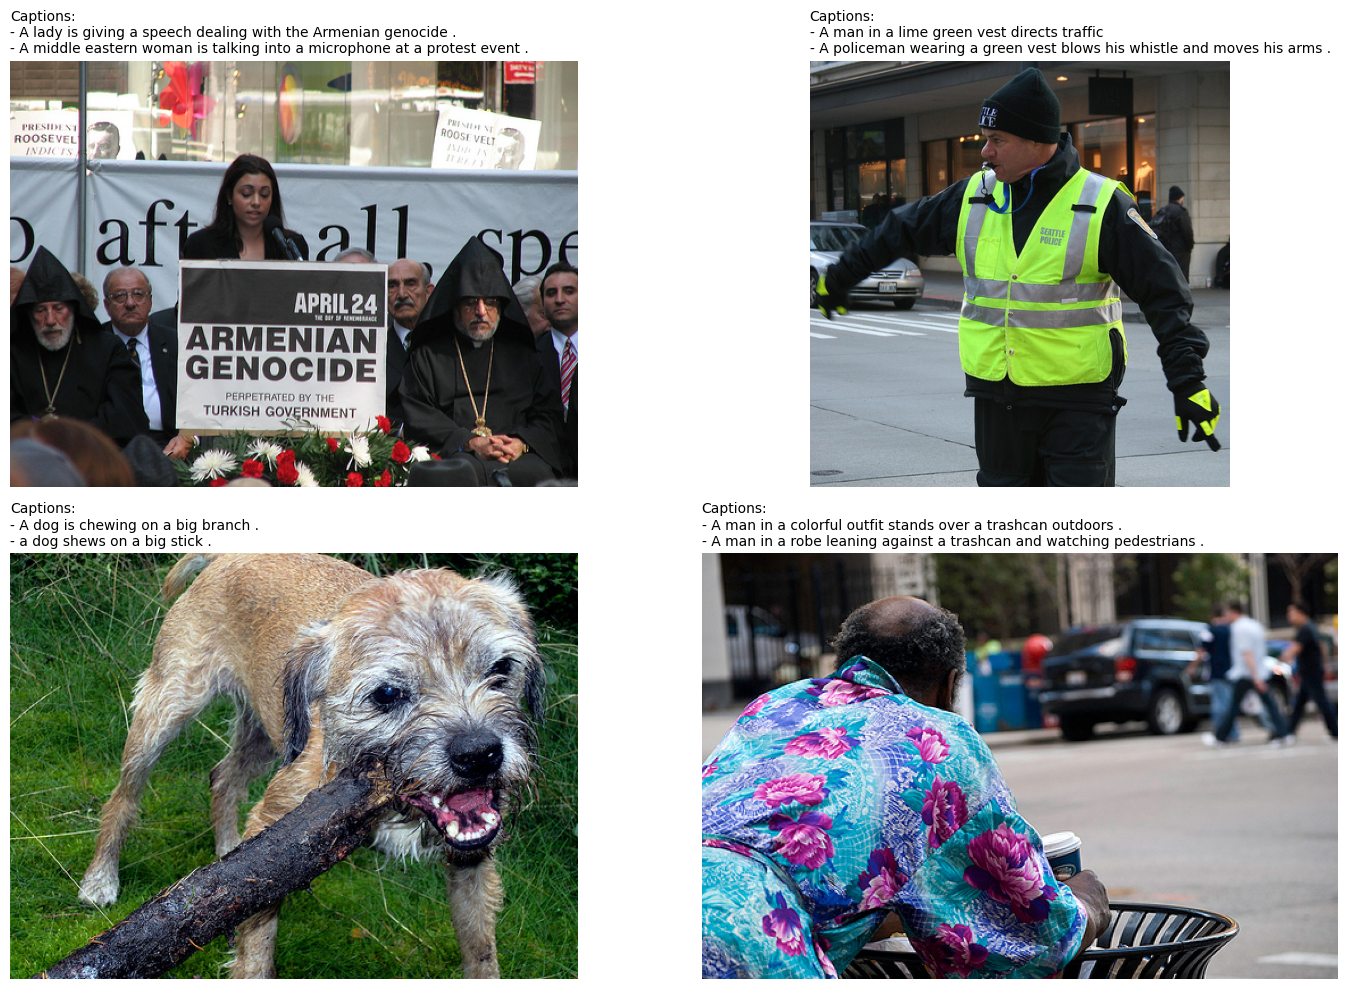

In [8]:
visualize_random_samples(data, Config.IMG_DIR, num_samples=4)

## 2. Tiền xử lý dữ liệu

In [9]:
train_loader, val_loader, test_loader, vocab = get_loaders(Config, data)

Vocabulary built! Size: 5231 words (Threshold: 2)
Data Split: Train=5663, Val=825, Test=1603 images


In [10]:
imgs, captions = next(iter(train_loader))
print(f"Images Shape: {imgs.shape}")
print(f"Captions Shape: {captions.shape}")

D:\Github\image-captioning-mini\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Images Shape: torch.Size([32, 3, 224, 224])
Captions Shape: torch.Size([32, 20])


In [11]:
sample_cap = captions[0]
print(f"Tensor: {sample_cap}")
print(f"Decoded: {vocab.denumericalize(sample_cap)}")

Tensor: tensor([   1,    4,    5,  342,  157,    4, 3572,  389,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Decoded: a child stand behind a cutout picture


## 3. Xây dựng Model: CNN Encoder + LSTM Decoder

### a. CNN Encoder (ResNet-18 Pretrained)
- Sử dụng ResNet-18 pretrained trên ImageNet
- Loại bỏ FC layer cuối, thay bằng một fully connected layer để project feature về embedding size

### b. LSTM Decoder
- Nhận image embedding làm hidden state khởi tạo
- Sử dụng teacher forcing trong quá trình training
- Output: distribution over vocabulary tại mỗi timestep

Running forward pass...
Input Image: torch.Size([4, 3, 224, 224])
Input Caption: torch.Size([4, 15])
Output Logits: torch.Size([4, 14, 3000])
✅ MODEL SHAPE MATCH! Ready for training.
